In [13]:
import pandas as pd
train_prompts = pd.read_csv('dataset/train_prompts.csv')
train_essays = pd.read_csv('dataset/train_essays.csv')
test_essays = pd.read_csv('dataset/test_essays.csv')
df_train_extra = pd.read_csv('dataset/train_v4_drcat_01.csv')

In [14]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Text(0.5, 1.0, 'Distribution of prompt ID')

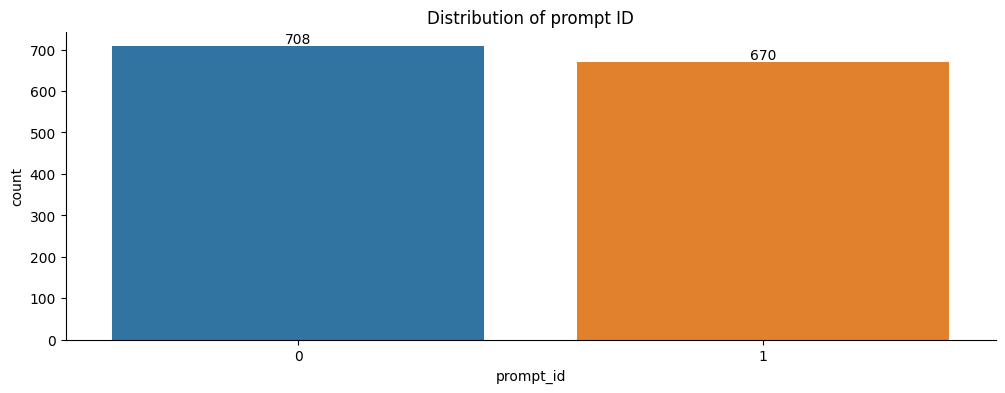

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays, x="prompt_id")

abs_values = train_essays['prompt_id'].value_counts().values

for i, v in enumerate(abs_values):
    ax.annotate(str(v), xy=(i, v), ha='center', va='bottom')

ax.set_title("Distribution of prompt ID")

Text(0.5, 1.0, 'Distribution of Generated Text')

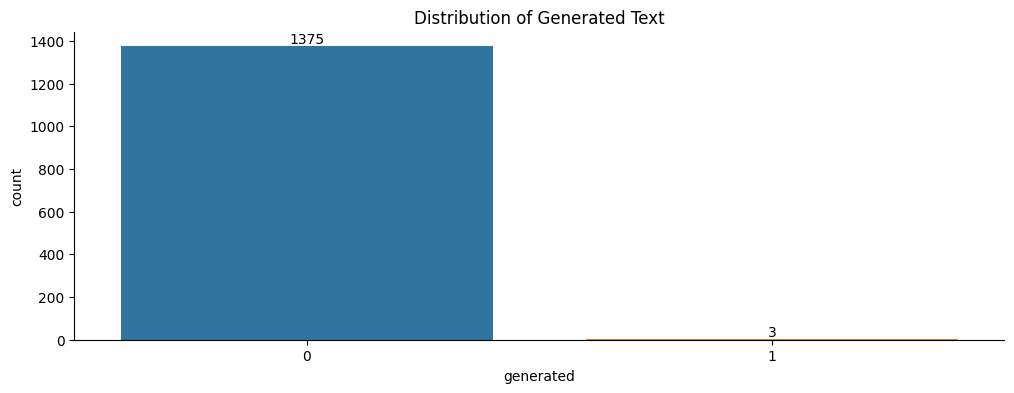

In [16]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays, x="generated")

abs_values = train_essays['generated'].value_counts().values

for i, v in enumerate(abs_values):
    ax.annotate(str(v), xy=(i, v), ha='center', va='bottom')

ax.set_title("Distribution of Generated Text")

In [17]:

df_train_extra.head()

,text,label,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,human
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,human
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,human
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,human
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,human


In [18]:
df_train_extra.rename(columns = {"label":"generated"}, inplace=True)

In [19]:
df_train_essays_final = pd.concat([df_train_extra[["text", "generated"]], train_essays[["text", "generated"]]])

df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74951 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       74951 non-null  object
 1   generated  74951 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [20]:
df_train_essays_final.isna().sum()

text         0
generated    0
dtype: int64

In [21]:
df_train_essays_final.dropna(inplace=True)


Text(0.5, 1.0, 'Distribution of Generated Text')

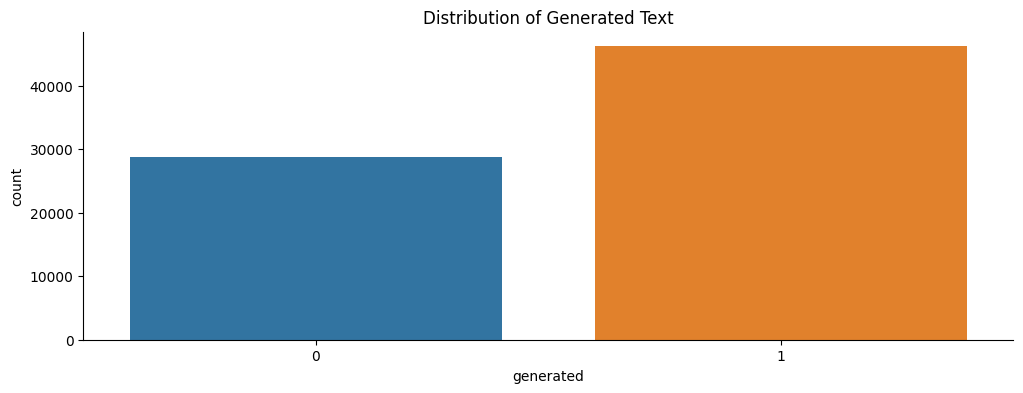

In [22]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_final,
                   x="generated")

abs_values = df_train_essays_final['generated'].value_counts().values
ax.set_title("Distribution of Generated Text")

In [23]:
#importing necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [24]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
def normalize(text):
    # Replace with whitespace to separate '😃\n\nFor'
    text = text.replace(r"\n", r" ")
    text = text.replace(r"\r", r" ")
    # Drop puntuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces from '😃  For' to '😃 For'
    text = re.sub(r"\s+", r" ", text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove leading and trailing whitespace
    text = text.strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #lower case the all capital alphabets
    text=text.lower()
    stop_words = set(stopwords.words('english'))
    word_tokens=word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    return text
from tqdm import tqdm
tqdm.pandas()
df_train_essays_final['text'] = df_train_essays_final['text'].progress_apply(lambda x: normalize(x))
test_essays['text'] = test_essays['text'].progress_apply(lambda x: normalize(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\27gur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\27gur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 3/3 [00:00<00:00, 1498.86it/s]


In [25]:
from tqdm import tqdm
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Preprocess your text data
inputs = []

for text in tqdm(df_train_essays_final['text'].tolist()):
    tokenized_text = tokenizer(text, padding=True, truncation=True, return_tensors="tf")
    inputs.append(tokenized_text['input_ids'].numpy()[0])  # Convert tensor to numpy array

# Pad your sequences
inputs = pad_sequences(inputs, padding='post')

# Split your dataset
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, df_train_essays_final['generated'].tolist(), test_size=0.2)

# Convert lists of inputs to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

c:\Users\27gur\.conda\envs\gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 74951/74951 [09:46<00:00, 127.84it/s]


In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the size of the encoded representation
encoding_dim = 32  # Adjust as needed

# Define the input layer
input_layer = Input(shape=(train_inputs.shape[1],))

# Define the encoder layers
encoder_layer1 = Dense(128, activation='relu')(input_layer)
encoder_layer2 = Dense(64, activation='relu')(encoder_layer1)
encoder_layer3 = Dense(encoding_dim, activation='relu')(encoder_layer2)

# Define the decoder layers
decoder_layer1 = Dense(64, activation='relu')(encoder_layer3)
decoder_layer2 = Dense(128, activation='relu')(decoder_layer1)
decoder_layer3 = Dense(train_inputs.shape[1], activation='sigmoid')(decoder_layer2)

# Create the autoencoder model
autoencoder = Model(input_layer, decoder_layer3)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder model


Epoch 1/100
235/235 [==============================] - 1s 5ms/step - loss: -2693191455211520.0000 - val_loss: -25293343726501888.0000
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: -1036707592316911616.0000 - val_loss: -4329416919443570688.0000
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: -24147126923542134784.0000 - val_loss: -64907399553756430336.0000
Epoch 4/100
235/235 [==============================] - 1s 5ms/step - loss: -188216687426881454080.0000 - val_loss: -392450321375389810688.0000
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: -832881008018366398464.0000 - val_loss: -1482188821300647034880.0000
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: -2632469386938506280960.0000 - val_loss: -4207262490414540652544.0000
Epoch 7/100
235/235 [==============================] - 1s 5ms/step - loss: -6670960888692221149184.0000 - val_loss: -9889425148345294258176.0000
Epoch 8/1

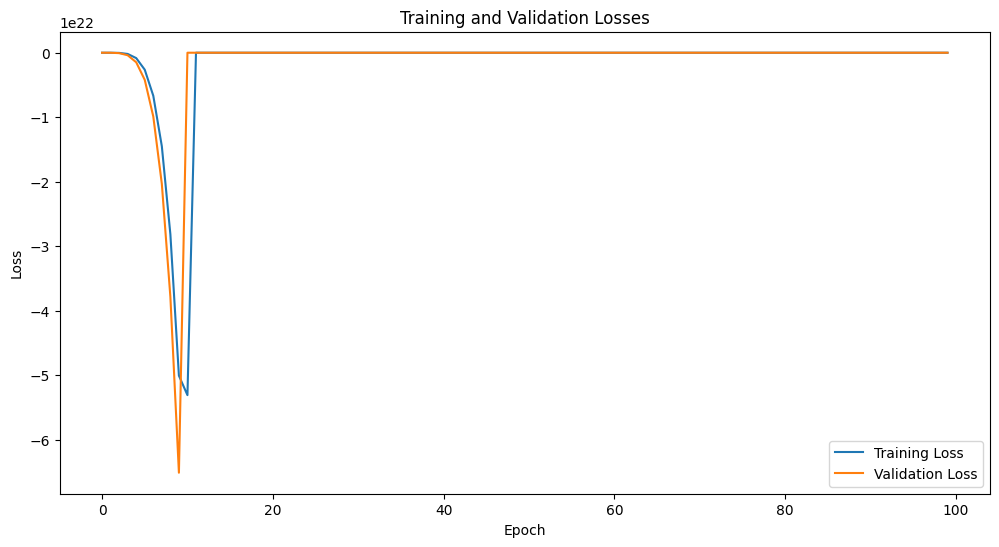

In [27]:
import matplotlib.pyplot as plt

# Train the autoencoder model and capture the history
history = autoencoder.fit(train_inputs, train_inputs, epochs=100, batch_size=256, shuffle=True, validation_data=(test_inputs, test_inputs))

# Print the history
print(history.history)

# Plot the training loss and validation loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# Create an encoder model from the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)

In [29]:
import numpy as np
# Initialize the progress bar
pbar = tqdm(total=len(train_inputs) + len(test_inputs), desc='Transforming features')

# Transform the train inputs and update the progress bar
train_encoded = []
for input in train_inputs:
    train_encoded.append(encoder.predict(input.reshape(1, -1)))
    pbar.update(1)

# Transform the test inputs and update the progress bar
test_encoded = []
for input in test_inputs:
    test_encoded.append(encoder.predict(input.reshape(1, -1)))
    pbar.update(1)

# Close the progress bar
pbar.close()

# Convert the lists to numpy arrays
train_encoded = np.array(train_encoded)
test_encoded = np.array(test_encoded)

Transforming features: 100%|██████████| 74951/74951 [39:41<00:00, 31.47it/s] 


In [34]:
# Reshape the train_encoded and test_encoded arrays
train_encoded_2d = train_encoded.reshape(train_encoded.shape[0], -1)
test_encoded_2d = test_encoded.reshape(test_encoded.shape[0], -1)

from sklearn import svm

# Train a SVM classifier on the encoded inputs
classifier = svm.SVC(probability=True, max_iter=1000)
classifier.fit(train_encoded_2d, train_labels)

# # Predict on the test data
# test_predictions = classifier.predict(test_encoded_2d)

# # Calculate the accuracy of the classifier
# accuracy = accuracy_score(test_labels, test_predictions)

y_pred = classifier.predict(test_encoded_2d)
accuracy = accuracy_score(test_labels, y_pred)
y_pred_proba = classifier.predict_proba(test_encoded_2d)[:, 1]  # Assuming 1 is the positive class
print(f"Accuracy: {accuracy}")

c:\Users\27gur\.conda\envs\gpu\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.6168367687279034


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, log_loss, matthews_corrcoef
import joblib

model_metrics = {
    'accuracy': accuracy_score(test_labels, y_pred),
    'precision': precision_score(test_labels, y_pred),
    'recall': recall_score(test_labels, y_pred),
    'f1': f1_score(test_labels, y_pred),
    'roc_auc': roc_auc_score(test_labels, y_pred_proba),
    'log_loss': log_loss(test_labels, y_pred_proba),
    'mcc': matthews_corrcoef(test_labels, y_pred)
}

# Print the computed metrics
for metric, value in model_metrics.items():
    print(f"{metric}: {value}")

# Save the metrics and probabilities
# joblib.dump(model_metrics, '/content/drive/MyDrive/dataset/modelbert_metrics.pkl')
# joblib.dump(y_pred_proba, '/content/drive/MyDrive/dataset/modelbert_y_pred_proba.pkl')

accuracy: 0.6168367687279034
precision: 0.6168367687279034
recall: 1.0
f1: 0.7630167505569767
roc_auc: 0.5
log_loss: 0.6655944928060671
mcc: 0.0


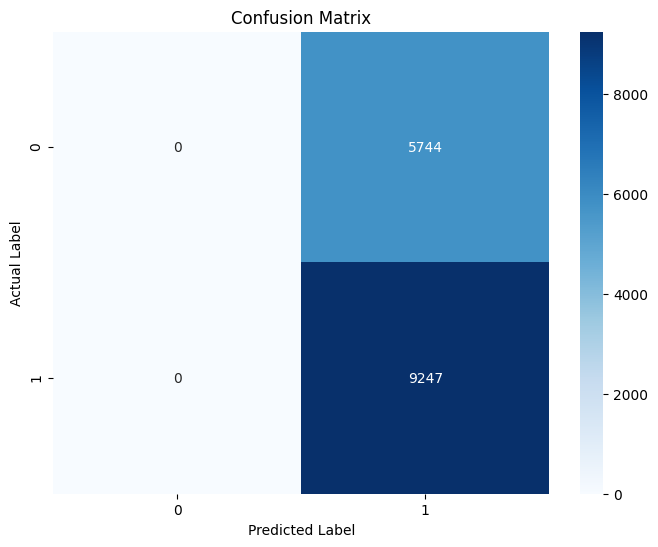

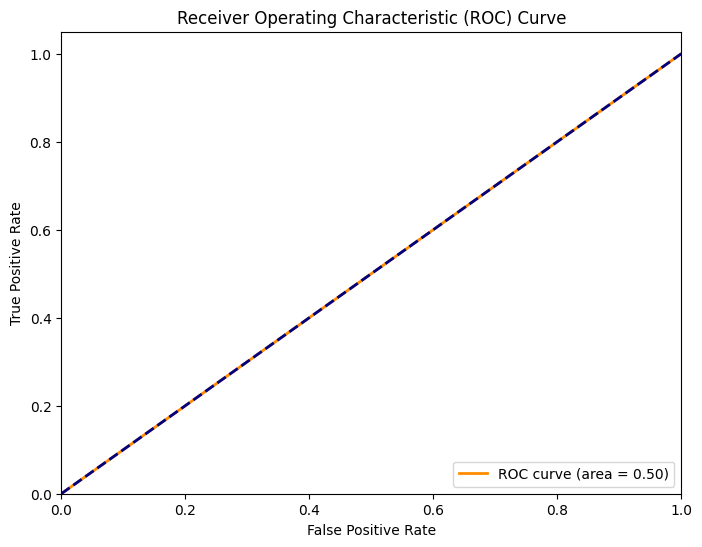

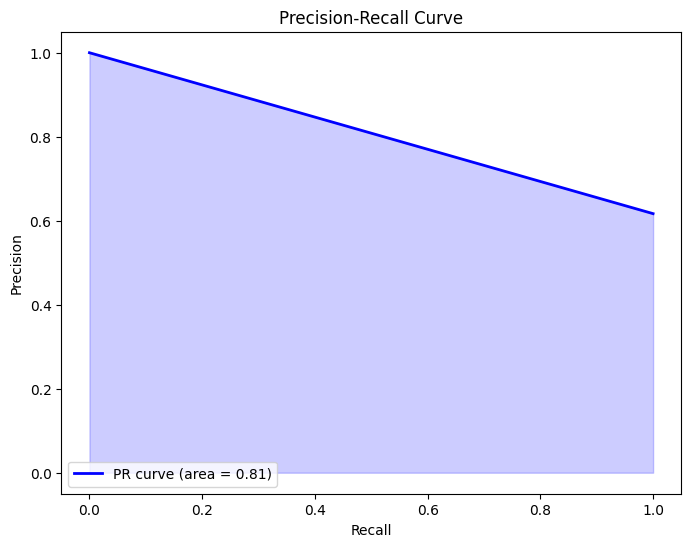

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Assuming you have `test_labels`, `y_pred`, and `y_pred_proba` available from your model's output

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_labels, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
